In [1]:
import os
import sys
sys.path.append('/nfs/h1/userhome/ChenXiaYu/workingdir/code/MagicBox')
import numpy as np
import nibabel as nib
import seaborn as sns
from os.path import join as pjoin
from matplotlib import pyplot as plt
from cxy_visual_dev.lib.predefine import proj_dir, Atlas, get_rois,\
    hemi2stru, hemi2Hemi
from magicbox.io.io import CiftiReader

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/distribution')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 画主次梯度值在EDLV四个部分内的分布

## hist+kde

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


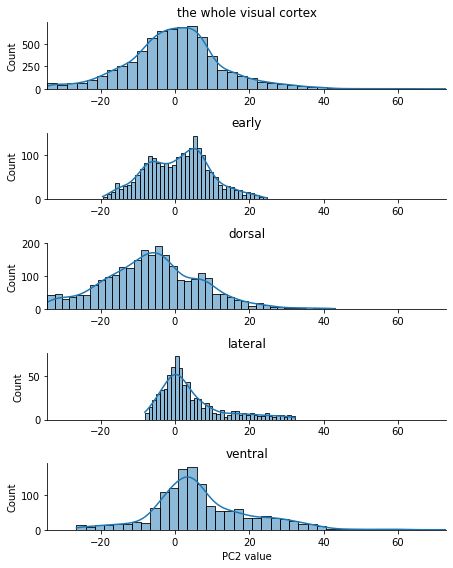

In [5]:
figsize = (6.4, 8)
pc_num = 2
hemi = 'lh'
Hemi = hemi2Hemi[hemi]
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
pc_file = pjoin(anal_dir, f'decomposition/HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii')
edlv_file = pjoin(proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_EDLV.dlabel.nii')
out_file = pjoin(work_dir, f'C{pc_num}-dist_in_EDLV-{Hemi}.jpg')
# out_file = 'show'

pc_map = nib.load(pc_file).get_fdata()[pc_num-1][vis_mask]
xlim = (pc_map.min(), pc_map.max())
reader = CiftiReader(edlv_file)
edlv_map = reader.get_data()[0, vis_mask]
lbl_tab = reader.label_tables()[0]
edlv_keys = np.unique(edlv_map)

n_edlv = len(edlv_keys)
fig, axes = plt.subplots(n_edlv + 1, 1, figsize=figsize)
ax = axes[0]
sns.histplot(data=pc_map, kde=True, ax=ax, bins=40)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(*xlim)
ax.set_title('the whole visual cortex')
for row_idx, k in enumerate(edlv_keys, 1):
    ax = axes[row_idx]
    data = pc_map[edlv_map == k]
    sns.histplot(data=data, kde=True, ax=ax, bins=40)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(*xlim)
    ax.set_title(lbl_tab[k].label.lstrip(f'{Hemi}_'))
ax.set_xlabel(f'PC{pc_num} value')

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)


## kde

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


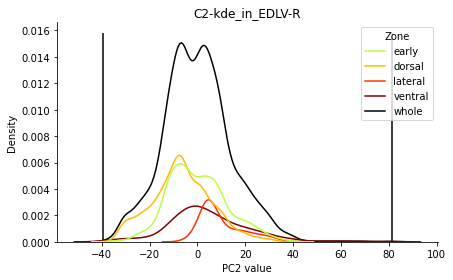

In [3]:
figsize = (6.4, 4)
pc_num = 2
Hemi = 'R'
edlv_names = ['early', 'dorsal', 'lateral', 'ventral']
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
pc_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii')
edlv_file = pjoin(anal_dir, 'divide_map/watershed-PC2_EDLV-seed-v1.dlabel.nii')
# edlv_file = pjoin(proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_EDLV.dlabel.nii')
out_name = f'C{pc_num}-kde_in_EDLV-{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

pc_map = nib.load(pc_file).get_fdata()[pc_num-1, vis_mask]
pc_range = (pc_map.min(), pc_map.max())
reader = CiftiReader(edlv_file)
edlv_map = reader.get_data()[0, vis_mask]
lbl_tab = reader.label_tables()[0]
edlv_keys = np.unique(edlv_map)
edlv_name2key = {}
edlv_name2color = {}
for edlv_k in edlv_keys:
    edlv_n = lbl_tab[edlv_k].label.lstrip(f'{Hemi}_')
    edlv_name2key[edlv_n] = edlv_k
    edlv_name2color[edlv_n] = lbl_tab[edlv_k].rgba

x_label = f'PC{pc_num} value'
data = {'Zone': [], x_label: []}
for edlv_n in edlv_names:
    mask = edlv_map == edlv_name2key[edlv_n]
    pc_values = pc_map[mask]
    data[x_label].extend(pc_values)
    data['Zone'].extend([edlv_n] * len(pc_values))
data[x_label] = np.r_[data[x_label], pc_map]
data['Zone'] = data['Zone'] + ['whole'] * len(pc_map)
edlv_name2color['whole'] = (0, 0, 0, 1)
fig, ax = plt.subplots(figsize=figsize)
sns.kdeplot(data=data, x=x_label, hue='Zone', palette=edlv_name2color, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ymin, ymax = ax.get_ylim()
ax.vlines(pc_range, ymin, ymax, color='k')
ax.set_title(out_name)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)
